# Facility Data Deep Dive

## Violations, Inspections and Enforcements for the Resource Conservation and Recovery Act (RCRA), Clean Water Act (CWA), Clean Air Act (CAA)

This notebook examines data from the EPA's Enforcement and Compliance History Online (ECHO) database (https://echo.epa.gov/). It includes information from EPA's programs covering air (the Clean Air Act, or CAA), water (the Clean Water Act, or CWA) hazardous and other waste handling (the Resource Recovery and Conservation Act, or RCRA), and public drinking water systems (Safe Drinking Water Act, or SDWA). 

ECHO data is available here on inspections, violations and enforcement actions by EPA, state and other agencies. Information made accessible here runs from the present day (the database is refreshed weekly) back to whenever ECHO data begins on a particular program (varying from the 1970s to the 2000s). It uses the following data sets from the ECHO downloadable files:

Hazardous and Other Wastes:
- RCRA_EVALUATIONS = Inspections under RCRA
- RCRA_VIOLATIONS = Violations of RCRA rules
- RCRA_ENFORCEMENTS = Enforcement actions takenby state agencies and the EPA

Cross-Program Compilations:
- ICIS_FEC_EPA_INSPECTIONS = Cross-program, federally-led inspections 
- CASE_FACILITIES = Cross-program enforcements
- ECHO_EXPORTER = A cross-program compilation of all information that is now available on the EPA's public interface for ECHO; mostly limited to the last 3-5 years of data

Air:
- ICIS-AIR_VIOLATION_HISTORY = CAA violations
- ICIS-AIR_FCES_PCES = Both state and federal CAA compliance evaluations
- ICIS-AIR_FORMAL_ACTIONS = CAA formal enforcement actions

Water:
- NPDES_QNCR_HISTORY = CWA Quarterly Non-Compliance History
- NPDES_INSPECTIONS = CWA Inspections
- NPDES_FORMAL_ENFORCEMENT_ACTIONS = CWA Enforcements

Drinking Water:
- SDWA_PUB_WATER_SYSTEMS = Public Water Systems under Safe Drinking Water Act
- SDWA_SITE_VISITS = Safe Drinking Water Site Visits
- SDWA_VIOLATIONS = Safe Drinking Water Violations
- SDWA_SERIOUS_VIOLATORS = Safe Drinking Water Serious Violators
- SDWA_ENFORCEMENTS = Safe Drinking Water Enforcements
- SDWA_RETURN_TO_COMPLIANCE = Safe Drinking Water Return to Compliance


#### For starters, please have available the zip code of the facility or area in which you are interested.  A zip code must be typed or pasted into the input widget that is provided after you run the first "cell."

A "cell" in a Jupyter notebook is a block of code performing a set of actions making available or using specific data.  The notebook works by running one cell after another, as the notebook user selects offered options.

## How to Run
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* **It is important to run cells in order because they depend on each other.**
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---
---

# **Let's begin!**

### Hover over the "[ ]" on the top left corner of the cell below and you should see a "play" button appear. Click on it to run the cell, then move to the next one.

### Run this next cell to create the widget to choose whether you want to view facilities by state, county, congressional district or zip code.  Choose the type of region and proceed to the next cell.

In [32]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display

# This is the global function that can run an SQL query against
# the database and return the resulting Pandas DataFrame.
def get_data( sql, index_field=None ):
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    # print( data_location )
    ds = pd.read_csv(data_location,encoding='iso-8859-1')
    if ( index_field is not None ):
        ds.set_index( index_field, inplace=True)
    return ds
 

# This class represents the data set and the fields and methods it requires 
# to retrieve data from the database.
class DataSet:
    def __init__( self, name, table_name, echo_type,
                 idx_field, date_field, date_format, agency_field, sql = None ):
        self.name = name                    #Friendly name 
        self.table_name = table_name        #Database table name
        self.echo_type = echo_type          #AIR, NPDES, RCRA, SDWA
        self.idx_field = idx_field          #The table's index field
        self.date_field = date_field
        self.date_format = date_format
        self.agency_field = agency_field
        self.sql = sql                      #The SQL query to retrieve the data 
        
    def get_data( self, ee_ids ):
        # The id_string can get very long for a state or even a county.
        # That can result in an error from too big URI.  Get the data in batches of 50 ids.

        id_string = ""
        program_data = None
        
        if ( len( ee_ids ) == 0 ):
            return None
              
        for pos,row in enumerate( ee_ids ):
            id_string = id_string + "'"+str(row)+"',"
            if ( pos % 50 == 0 ):
                id_string=id_string[:-1] # removes trailing comma
                data = self._try_get_data( id_string )   
                if ( program_data is None ):
                    program_data = data
                else:
                    program_data = pd.concat([ program_data, data ])
                id_string = ""

        if ( pos % 50 != 0 ):
            id_string=id_string[:-1] # removes trailing comma
            data = self._try_get_data( id_string )
            if ( program_data is None ):
                program_data = data
            else:
                program_data = pd.concat([ program_data, data ])
                
        return program_data
                
    def _try_get_data( self, id_list ):
        this_data = None
        try:
            # breakpoint()
            if ( self.sql is None ):
                x_sql = "select * from `" + self.table_name + "` where " \
                            + self.idx_field + " in (" \
                            + id_list + ")"
            else:
                x_sql = self.sql + "(" + id_list + ")"
            this_data = get_data( x_sql, self.idx_field )
            # print( "Data found from " + self.table_name )
        except pd.errors.EmptyDataError:
            print( "..." )
        return this_data
    
    def get_echo_ids( self, echo_data ):
        echo_id = self.echo_type + '_IDS'
        if ( self.echo_type == 'SDWA' ):
            echo_flag = 'SDWIS_FLAG'
        else:
            echo_flag = self.echo_type + '_FLAG'
        my_echo_ids = echo_data[ echo_data[ echo_flag ] == 'Y' ][ echo_id ]
        return my_echo_ids
        
    def has_echo_flag( self, echo_data ):
        if ( self.echo_type == 'SDWA' ):
            echo_flag = 'SDWIS_FLAG'
        else:
            echo_flag = self.echo_type + '_FLAG'
        my_echo_data = echo_data[ echo_data[ echo_flag ] == 'Y' ]
        return len( my_echo_data ) > 0
        
region_field = { 
    'County': { "field": 'FAC_COUNTY' },
    'State': { "field": 'FAC_STATE' },
    'Congressional District': { "field": 'FAC_DERIVED_CD113' },
    'Zip Code': { "field": 'FAC_DERIVED_ZIP' }
}

select_region_widget = widgets.Dropdown(
    options=region_field.keys(),
    value='County',
    description='Region of interest:',
    disabled=False
)
display( select_region_widget )

Dropdown(description='Region of interest:', options=('County', 'State', 'Congressional District', 'Zip Code'),…

### Select the state of interest.  If you chose Zip Code above, this cell can be skipped.

In [33]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

### If you are looking at a county or congressional district, after selecting a state from the dropdown above, run this cell to pick your region.  
### Run this cell for county, congressional district or zip code regions.  

If you are interested in an analysis by state, it is already selected so skip this cell.

In [34]:
selected_region_type = select_region_widget.value
selected_region_field = region_field[ selected_region_type ]

if ( selected_region_type != 'Zip Code' ):
    my_state = dropdown_state.value
    region_sql = "select distinct("
    region_sql += selected_region_field[ 'field' ] + ")"
    region_sql += " from ECHO_EXPORTER "
    region_sql += " where FAC_STATE = \'" + my_state + "\'"
    try:
        regions = get_data( region_sql )
    except pd.errors.EmptyDataError:
        print("\nThere are no regions of that type in this state.\n")

if ( selected_region_type == 'Zip Code' ):
    region_widget = widgets.IntText(
        value=98225,
        description='Zip Code:',
        disabled=False
    )
elif ( selected_region_type == 'County' ):
    region_widget=widgets.Dropdown(
        options=regions['FAC_COUNTY'].sort_values(),
        description='County:',
        disabled=False
    )
elif ( selected_region_type == 'Congressional District' ):
    region_widget=widgets.Dropdown(
        options=regions['FAC_DERIVED_CD113'].sort_values(),
        description='District:',
        disabled=False
    )
   
if ( selected_region_type != 'State' ):
    display( region_widget )

Dropdown(description='District:', options=(1, 2, 3, 4, 5, 6, 7, 10, 15, 18, 22, 36), value=1)

### Run this cell. It will pull facility information for your selected are of interest from the data in the  ECHO_EXPORTER table.

In [39]:
region_selected = region_widget.value

if ( selected_region_type == 'State' ):
    region_selected = my_state
elif ( selected_region_type == 'County' and  region_selected.endswith( ' COUNTY' )):
    region_selected = region_selected[:-7]
echo_data_sql = "select * from ECHO_EXPORTER where " + region_field[selected_region_type]['field']
echo_data_sql += " like \'" + str( region_selected) + "%\'"
if ( selected_region_type != 'Zip Code' ):
    echo_data_sql += " and FAC_STATE = \'" + my_state + "\'"
try:
    echo_data = get_data( echo_data_sql, 'REGISTRY_ID' )
    num_facilities = echo_data.shape[0]
    print("\nThere are %s EPA facilities in region %s tracked in the ECHO database." \
          %(num_facilities, str( region_selected )))
except pd.errors.EmptyDataError:
    print("\nThere are no EPA facilities in this region.\n")


There are 5750 EPA facilities in region 2 tracked in the ECHO database.


In [40]:
echo_data

,FAC_NAME,FAC_STREET,FAC_CITY,FAC_STATE,FAC_ZIP,FAC_COUNTY,FAC_FIPS_CODE,FAC_EPA_REGION,FAC_INDIAN_CNTRY_FLG,FAC_FEDERAL_FLG,...,FAC_DATE_LAST_INSPECTION_EPA,FAC_DATE_LAST_INSPECTION_STATE,FAC_DATE_LAST_FORMAL_ACT_EPA,FAC_DATE_LAST_FORMAL_ACT_ST,FAC_DATE_LAST_INFORMAL_ACT_EPA,FAC_DATE_LAST_INFORMAL_ACT_ST,FAC_FEDERAL_AGENCY,TRI_REPORTER,FAC_IMP_WATER_FLG,EJSCREEN_FLAG_US
REGISTRY_ID,,,,,,,,,,,,,,,,,,,,,
110003320273,DRY CLEANING BY LOUIS,7300 READ BLVD,NEW ORLEANS,LA,70127.0,ORLEANS,22071,6,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
110003260211,NALCO CO,3520 GEN DEGAULLE DR STE 3090,NEW ORLEANS,LA,70114.0,ORLEANS,22071,6,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
110037937285,US ARMY CORPS OF ENGINEERS,DWYER ROAD INTAKE CANAL,NEW ORLEANS,LA,70160.0,ORLEANS,22071,6,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
110010120788,TESI - PLANTATION GARDENS,"ON KNOTTAWAY DR, EXT; OFF LA 3",SUNSHINE,LA,70780.0,IBERVILLE,22047,6,N,NaN,...,NaN,04/28/2009,02/06/2015,11/10/2014,NaN,11/21/2008,NaN,NaN,NaN,N
110003317054,LEONARDS AUTO RPR,230 TAYLOR ST,BATON ROUGE,LA,70802.0,EAST BATON ROUGE,22033,6,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
110024584270,RUDDOCK WELL TREATMENT,4280 HWY 51 SERVICE ROAD OFF I-10,LAPLACE,LA,70068.0,ST JOHN THE BAPTIST,22095,6,N,NaN,...,NaN,12/18/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
110056317418,WALGREEN DRUG STORE 9063,134 ROYAL ST,NEW ORLEANS,LA,70130.0,ORLEANS,22071,6,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
110003273573,LEE CIRCLE TEXACO,919 ST CHARLES ST,NEW ORLEANS,LA,70130.0,ORLEANS,22071,6,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
110001263007,MONTELEPRE EXTENDED CARE HOSPITAL,3125 CANAL ST,NEW ORLEANS,LA,70119.0,ORLEANS,22071,6,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y


## Create an interactive map of all of the facilities in this area that report to EPA
### Once you run this cell, a map should appear. You can zoom in and out, or click on facilities to get their names and the EPA programs that monitor them.

The EPA program acronyms are:
- CAA = Clean Air Act
- CWA = Clean Water Act
- SDWIS = Safe Drinking Water Information System
- RCRA = Resource Conservation and Recovery Act
- TRI = Toxics Release Inventory
- GHG = Greenhouse Gas

The map won't display if there are too many markers, so only the first 400 are shown. 
The facilities shown are selected in order of the ECHO_EXPORTER table's FAC_QTRS_WITH_NC field, which is defined as a "Count of the number of quarters, out of the last twelve quarters, in which the permit or site is considered either in Noncompliance (NC), Significant Noncompliance (SNC) or High Priority violation (HPV) status."

In [ ]:
# [To do:  Use some ECHO_EXPORTER data to pick the top facilities (by some measure) 
# to map.]

# Let's show a quick map of your area and the facilities in it
# To-do:  Add some more ECHO_EXPORTER information in the markers.

# Put some information with the marker to show the programs that track the facility.
def marker_text( row ):
    text = ""
    if ( type( row['FAC_NAME'] == str )) :
        try:
            text = row["FAC_NAME"] + ' - '
        except TypeError:
            print( "A facility was found without name. ")
        if ( row['AIR_FLAG'] == 'Y' ):
            text += 'CAA, ' 
        if ( row['NPDES_FLAG'] == 'Y' ):
            text += 'CWA, ' 
        if ( row['SDWIS_FLAG'] == 'Y' ):
            text += 'SDWIS, ' 
        if ( row['RCRA_FLAG'] == 'Y' ):
            text += 'RCRA, ' 
        if ( row['TRI_FLAG'] == 'Y' ):
            text += 'TRI, ' 
        if ( row['GHG_FLAG'] == 'Y' ):
            text += 'GHG, ' 
    return text
    
def mapper(df):
    # Initialize the map
    center = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]]
    m = folium.Map(
        location = center,
    )

    # Add a clickable marker for each facility
    i = 0
    for index, row in df.iterrows():
        # Make sure the FAC_NAME is not NaN, which is interpreted as a number.
        if ( type( row['FAC_NAME'] == str )) :
            folium.Marker(
                location = [row["FAC_LAT"], row["FAC_LONG"]],
                popup = marker_text( row )).add_to(m)
            i += 1
        if ( i > 400 ):    # The map won't display with too many markers.
            break
            
    bounds = m.get_bounds()
    m.fit_bounds(bounds)
    
    # Show the map
    return m

df_to_map = echo_data
if ( len(df_to_map) > 400 ):
    df_to_map = echo_data[echo_data["FAC_QTRS_WITH_NC"] > 0].sort_values(by="FAC_QTRS_WITH_NC", ascending=False)
    
map_of_facilities = mapper(df_to_map)
map_of_facilities

## In this section you may save the summary data for this region to your computer.
This next cell allows you to save the data from ECHO_EXPORTER for your chosen region to your computer.

_Note: When you click on [] in the cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown..._

In [ ]:
filename = 'EchoExporter-' + region_selected
fullpath = filename+'.csv'
echo_data.to_csv( fullpath ) 

print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))

In [6]:
ds = DataSet( name='RCRA Violations', idx_field='ID_NUMBER', 
                table_name='RCRA_VIOLATIONS', echo_type="RCRA",
                date_field='DATE_VIOLATION_DETERMINED', date_format='%m/%d/%Y')
data_sets[ ds.name ] = ds
ds = DataSet( name='RCRA Inspections', idx_field='ID_NUMBER', 
                table_name='RCRA_EVALUATIONS', echo_type="RCRA",
                date_field='EVALUATION_START_DATE', date_format='%m/%d/%Y')
data_sets[ ds.name ] = ds
ds = DataSet( name='RCRA Enforcements',  echo_type="RCRA",
                table_name='RCRA_ENFORCEMENTS', idx_field='ID_NUMBER', 
                date_field='EVALUATION_START_DATE', date_format='%m/%d/%Y' )
data_sets[ ds.name ] = ds
# Special sql queries needed for Air Inspections and Air Enforcements
my_sql = "select * from `ICIS_FEC_EPA_INSPECTIONS` where REGISTRY_ID in "
ds = DataSet( name='Air Inspections', echo_type="AIR",
                table_name='ICIS_FEC_EPA_INSPECTIONS', idx_field='REGISTRY_ID', 
                date_field='ACTUAL_END_DATE', date_format='%m/%d/%Y', sql=my_sql )
data_sets[ ds.name ] = ds
my_sql = "select * from `CASE_FACILITIES` CF, `CASE_ENFORCEMENTS` CE " + \
            " where CE.HQ_DIVISION = 'AIR' and CE.CASE_NUMBER = CF.CASE_NUMBER and " + \
            " CF.REGISTRY_ID in "
ds = DataSet( name='Air Enforcements',  echo_type="AIR",
                table_name='CASE_ENFORCEMENTS', idx_field='REGISTRY_ID',
                date_field='FISCAL_YEAR', date_format='%Y', sql=my_sql )
data_sets[ ds.name ] = ds
ds = DataSet( name='Air Violations',  echo_type="AIR",
                table_name='ICIS-AIR_VIOLATION_HISTORY', idx_field='PGM_SYS_ID', 
                date_field='HPV_DAYZERO_DATE', date_format='%m-%d-%Y' )
data_sets[ ds.name ] = ds
ds = DataSet( name='Air Formal Actions', echo_type="AIR",
                table_name='ICIS-AIR_FORMAL_ACTIONS', idx_field='PGM_SYS_ID',
                date_field='SETTLEMENT_ENTERED_DATE', date_format='%m/%d/%Y' )
data_sets[ ds.name ] = ds
ds = DataSet( name='Air Compliance', echo_type="AIR",
                table_name='ICIS-AIR_FCES_PCES', idx_field='PGM_SYS_ID',
                date_field='ACTUAL_END_DATE', date_format='%m-%d-%Y' )
data_sets[ ds.name ] = ds
ds = DataSet( name='Water Quarterly Violations', echo_type="NPDES",
                table_name='NPDES_QNCR_HISTORY', idx_field='NPDES_ID',
                date_field='YEARQTR', date_format='%Y' )
ds = DataSet( name='Clean Water Enforcements', echo_type="NPDES",
                table_name='NPDES_FORMAL_ENFORCEMENT_ACTIONS', idx_field='NPDES_ID',
                date_field='SETTLEMENT_ENTERED_DATE', date_format='%m/%d/%Y' )
data_sets[ ds.name ] = ds
ds = DataSet( name='SDWA Site Visits', echo_type="SDWA",
                table_name='SDWA_SITE_VISITS', idx_field='PWSID',
                date_field='SITE_VISIT_DATE', date_format='%m/%d/%Y' )
data_sets[ ds.name ] = ds
ds = DataSet( name='SDWA Enforcements', echo_type="SDWA",
                table_name='SDWA_ENFORCEMENTS', idx_field='PWSID',
                date_field='ENFORCEMENT_DATE', date_format='%m/%d/%Y' )
data_sets[ ds.name ] = ds
ds = DataSet( name='SDWA Public Water Systems', echo_type="SDWA",
                table_name='SDWA_PUB_WATER_SYSTEMS', idx_field='PWSID',
                date_field='FISCAL_YEAR', date_format='%Y' )
data_sets[ ds.name ] = ds
ds = DataSet( name='SDWA Violations', echo_type="SDWA",
                table_name='SDWA_VIOLATIONS', idx_field='PWSID',
                date_field='FISCAL_YEAR', date_format='%Y' )
data_sets[ ds.name ] = ds
ds = DataSet( name='SDWA Serious Violators', echo_type="SDWA",
                table_name='SDWA_SERIOUS_VIOLATORS', idx_field='PWSID',
                date_field='FISCAL_YEAR', date_format='%Y' )
data_sets[ ds.name ] = ds
ds = DataSet( name='SDWA Return to Compliance', echo_type="SDWA",
                table_name='SDWA_RETURN_TO_COMPLIANCE', idx_field='PWSID',
                date_field='FISCAL_YEAR', date_format='%Y' )

TypeError: __init__() missing 1 required positional argument: 'agency_field'

In [41]:
# Create a DataSet object for each of the programs we track.  
# Initialize each one with the information it needs to do its query
# of the database.
# Store the DataSet objects in a dictionary with keys being the
# friendly names of the program, which will be used in selection
# widgets.

data_sets = {}

ds = DataSet( name='Clean Water Inspections', echo_type="NPDES",
                table_name='NPDES_INSPECTIONS', idx_field='NPDES_ID',
                date_field='ACTUAL_END_DATE', date_format='%m/%d/%Y', agency_field='STATE_EPA_FLAG')
data_sets[ ds.name ] = ds
ds = DataSet( name='Water Quarterly Violations', echo_type="NPDES",
                table_name='NPDES_QNCR_HISTORY', idx_field='NPDES_ID',
                date_field='YEARQTR', date_format='%Y', agency_field='STATE_EPA_FLAG')
data_sets[ ds.name ] = ds


### We need to set up some data structures in this next cell that will be used in the remainder of the report.

## Graph program-specific data for all the facilities in the region.
### First, choose the program (Air, Water, Hazardous Waste, or Drinking Water) and type of data (Violations, Inspections, Enforcement Actions) you want to explore

Running the code below will show you a dropdown you can use to make a selection. **Inspections** or **evaluations** are usually the first phase in the enforcement pipeline. Inspections are how many (but not all) violations are discovered.  **Violations** happen when a facilty is found to be out of compliance with an environmental law, often by violating the terms of its permit issued under that law.  **Enforcement actions** happen when the regulating agency decides to initiate a "case" against a firm for its violation of an environmental law, either by considering some administrative penalty such as a fine or by taking the violator to court. 

What's available for you to look at here:

Hazardous and Other Waste:
- RCRA_EVALUATIONS = Inspections under RCRA
- RCRA_VIOLATIONS = Violations of RCRA rules
- RCRA_ENFORCEMENTS = Enforcement actions taken by state agencies and the EPA

Here's where you can find definitions of terms used in the columns of RCRA data: 
https://echo.epa.gov/tools/data-downloads/rcrainfo-download-summary 
Air:
- ICIS-AIR_VIOLATION_HISTORY = CAA violations
- ICIS-AIR_FCES_PCES = Both state and federal CAA compliance evaluations
- ICIS-AIR_FORMAL_ACTIONS = CAA formal enforcement actions
- ICIS_FEC_EPA_INSPECTIONS = Cross-program, federally-led inspections  
- CASE_FACILITIES = Cross-program enforcements


Here's where you can find definitions of terms used in the columns of Clean Air Act data: 
https://echo.epa.gov/tools/data-downloads/icis-air-download-summary

Water (National Pollutant Discharge Elimination System, or NPDES):
- NPDES_QNCR_HISTORY = CWA Quarterly Non-Compliance History
- NPDES_INSPECTIONS = CWA Inspections
- NPDES_FORMAL_ENFORCEMENT_ACTIONS = CWA Enforcements

Here's where you can find definitions of terms used in the columns of Clean Water Act data: https://echo.epa.gov/tools/data-downloads/icis-npdes-download-summary


Drinking Water (Safe Drinking Water Act, or SDWA):
- SDWA_PUB_WATER_SYSTEMS = Public Water Systems under Safe Drinking Water Act
- SDWA_SITE_VISITS = Safe Drinking Water Site Visits
- SDWA_VIOLATIONS = Safe Drinking Water Violations
- SDWA_SERIOUS_VIOLATORS = Safe Drinking Water Serious Violators
- SDWA_ENFORCEMENTS = Safe Drinking Water Enforcements
- SDWA_RETURN_TO_COMPLIANCE = Safe Drinking Water Return to Compliance

Here's where you can find definitions of terms used in the columns of Clean Water Act data: https://echo.epa.gov/tools/data-downloads/sdwa-download-summary



In [42]:
# Only list the data set if it has the correct flag set.
data_set_choices = []
for k, v in data_sets.items():
    if ( v.has_echo_flag( echo_data ) ):
        data_set_choices.append( k )

# data_set_choices = list( data_sets.keys() )

data_set_widget=widgets.Dropdown(
    options=list(data_set_choices),
    description='Data sets:',
    disabled=False,
) 
display(data_set_widget)

Dropdown(description='Data sets:', options=('Clean Water Inspections', 'Water Quarterly Violations'), value='C…

### Once you've chosen the program and data type you want to focus on...
....run the code below, which will access our database and retrieve the information

In [56]:
program = data_sets[ data_set_widget.value ]

ids_string = program.echo_type + '_IDS'
ids = echo_data.loc[echo_data[ids_string].str.len() >0]    # just give all _IDs and let sql deal with it?
ids = ids.loc[:,ids_string].unique()
for x in ids:
    print(x)

LAR10F385
LAG540067
LA0121509
LAG534955
LAG534763
LAG750877
LAR05P132
LAG470325
LAU006426
LAG530758
LAG750596 LAG751052
LAR10E221
LAU008048
LAG560032
LA0080101
LAR10G839
LAR05P170
LAR10G904
LAR05M758
LAR10F505
LAU003410
LAR10J471 LAR10J489
LAR05M149
LAG535054
LAR10H637 LAR10H726 LAR10J443
LAU006940
LA0000418 LAG670075 LAG670171 LAR05N079 LAR10G881 LAR10J168 LAR10J366
LAR05M802
LAU003555
LAR05P727
LAG470405
LA0127226
LAG534709 LAG750808 LAR05P333 LAR10G663
LAU004910
LAG541296
LAR10N396
LAR10M862
LA0083216
LAG480334
LAR05P218
LA0124435 LAG030001
LAR05P248 LAU004946
LAG480032
LAG534855
LAR10J289
LA0050695
LAG534720
LAR05N023
LAG751088
LAG470204
LAU007964
LAR10L072
LAG541922 LAR10H936 LAR10J706
LAG030015
LAG535000
LAR05P402 LAU006888
LA0052353 LAG420020 LAG480776
LAR10F396 LAR10H041
LAG490039
LAR10J011
LAG490029
LAG560092
LAU007970
LAR05B380
LAR10H036
LAR05N498 LAR05Q046
LA0003751 LAG670109 LAJ660225 LAJ660226 LAR10F072
LAG530181 LAG540280
LAU003467
LAG480331 LAR05N015
LA0093238
LAG750766


LA0029769
LAG531163
LAR05N422
LA0007382
LAR10F995
LAU003545
LAR05N691
LAR05M565
LAR10K897
LAU003281
LAG535563
LAG541654
LAU003546
LA0079961
LAR05P687
LAG534997
LAR10M545
LAG530941
LAG531604
LA0096512
LAU008063
LA0073091
LA0104655
LAR10F999
LAR05P671
LA0119423
LAU003539
LAR05M767
LAU003374
LAR05N868 LAR05Q064
LAU006558
LAR05M298
LAU007633
LAR05P581
LAR05P336
LAU003440
LAU003308
LAR05P743
LAR10N114
LAR10M179
LAR10G773
LAR10K493 LAR10K494
LA0087785
LAR10C412
LAG480385
LAR05N347
LAR05P504 LAR10H115
LAG536086
LAG533911
LA0107107
LAG532433 LAU005137
LAU007958
LAR05M131
LAG480010
LAG750762
LA0111180
LAG480313 LAU009474
LAG119007 LAG119023
LAR10N073
LAG535805
LAR10E796
LAU009140
LAG534916
LAG490119
LAG380033
LAG481015 LAU007893
LA0059455
LAU004057
LAU004542
LAR10J330
LAR05A037
LAR10K313
LAU004900
LAU007517
LAU009493
LAU003453
LAR10L385
LAG490030
LAR10H328
LAG670169 LAR05P753 LAR10J916
LAR10J191
LAU003352
LAG541594 LAU005337
LAR10N556
LAU007375
LAR10J353 LAR10J363
LA0001023
LAG480697
LAL038091


In [57]:
program = data_sets[ data_set_widget.value ]

ids_string = program.echo_type + '_IDS'
ids = echo_data.loc[echo_data[ids_string].str.len() >0]    # just give all _IDs and let sql deal with it?
ids = ids.loc[:,ids_string].unique()

program_data = None
# We need to provide a custom sql query and argument for these programs.
if ( program.name == "Air Inspections" or program.name == "Air Enforcements" ):
    # The REGISTRY_ID field is the index of the echo_data
    # Build a string
    registry_ids = echo_data[echo_data['AIR_FLAG'] == 'Y'].index.to_list()
    program_data = program.get_data( ee_ids=registry_ids )
else:
    program_data = program.get_data( ee_ids=ids )

program_data

...


,REGISTRY_ID,ACTIVITY_ID,ACTIVITY_TYPE_CODE,COMP_MONITOR_TYPE_CODE,COMP_MONITOR_TYPE_DESC,STATE_EPA_FLAG,ACTUAL_BEGIN_DATE,ACTUAL_END_DATE,ACTIVITY_OUTCOME_CODE,ACTIVITY_OUTCOME_DESC
NPDES_ID,,,,,,,,,,
LA0050695,110000449818,1600297823,INS,CEI,Evaluation,S,NaN,06/01/1999,NaN,NaN
LA0050695,110000449818,1600297827,INS,CEI,Evaluation,S,NaN,02/28/1983,NaN,NaN
LA0050695,110000449818,1600297824,INS,CEI,Evaluation,S,NaN,02/22/1995,NaN,NaN
LA0050695,110000449818,1600297822,INS,CEI,Evaluation,S,NaN,10/05/2000,NaN,NaN
LA0050695,110000449818,1600297821,INS,CEI,Evaluation,S,NaN,08/27/2002,NaN,NaN
LA0050695,110000449818,1600297829,INS,CEI,Evaluation,S,NaN,02/26/1982,NaN,NaN
LA0050695,110000449818,1600297614,INS,CEI,Evaluation,S,NaN,12/16/2004,NaN,NaN
LA0050695,110000449818,2200023513,INS,CEI,Evaluation,S,09/01/2010,09/01/2010,NaN,NaN
LA0050695,110000449818,1600297827,INS,SA1,Sampling,S,NaN,02/28/1983,NaN,NaN


## In this section you may save the program data for your region to your computer.
This next cell allows you to save the data from the particular program for your chosen region to your computer.

_Note: When you click on [] in the cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown..._

In [50]:
filename = program.name + '-' + str(region_selected)
fullpath = filename+'.csv'
program_data.to_csv( fullpath ) 

print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))

Wrote Water Quarterly Violations-2 to the Google Colab 'Files' menu as Water Quarterly Violations-2.csv


### Let's make a chart out of this!

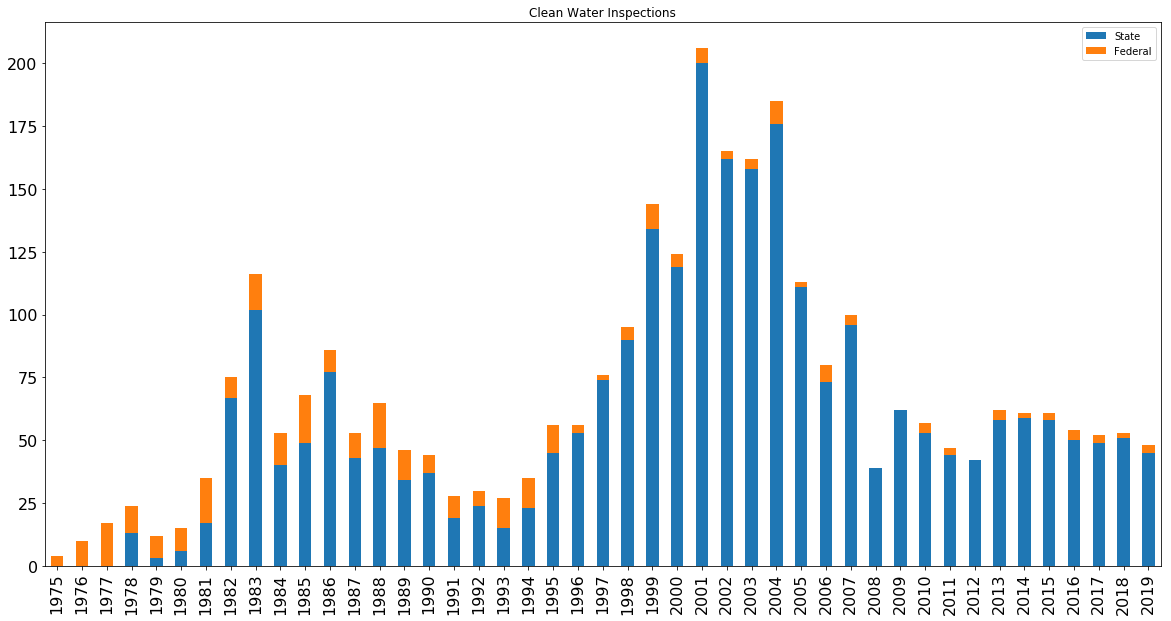

In [60]:
program_data['State'] = np.where(program_data[program.agency_field]=="S", 1,0)
program_data['Federal']= np.where(program_data[program.agency_field]=="E", 1,0)

g = program_data.groupby([pd.to_datetime(program_data[program.date_field], format=program.date_format)])[["State", "Federal"]].sum()
g = g.resample("Y").sum()
g.index = g.index.strftime('%Y')
g

ax = g.plot(kind='bar', stacked=True, title = program.name, figsize=(20, 10), fontsize=16)
ax

In [51]:
d = program_data.groupby(pd.to_datetime(program_data['YEARQTR'], format="%Y").dt.to_period("Y")).sum()
#d = d.resample("Y").sum()
#d.index = d.index.strftime('%Y')
d
#ax = d.plot(kind='bar', title = chart_title, figsize=(20, 10), legend=False, fontsize=16)
#ax

,NUME90Q,NUMCVDT,NUMSVCD,NUMPSCH
YEARQTR,,,,
1977,0,0,0,1
1987,0,0,2,0
1988,0,15,1,0
1989,1,57,13,0
1990,0,15,23,0
1991,14,24,27,0
1992,9,22,25,0
1993,49,50,44,0
1994,51,53,40,1


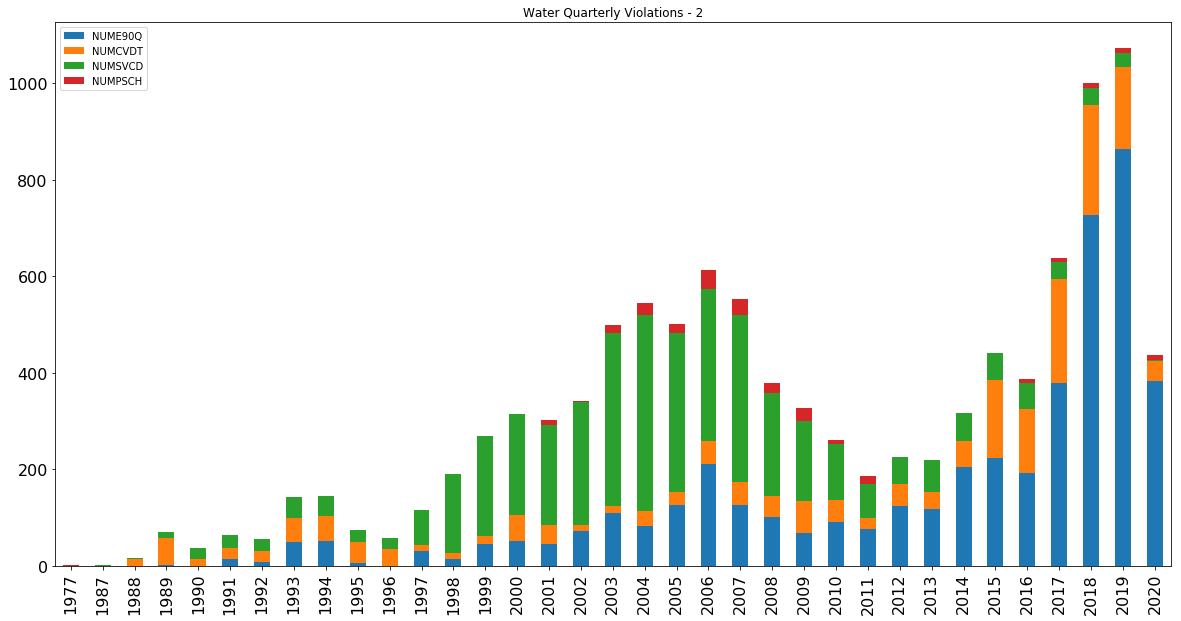

In [45]:
chart_title = program.name + ' - ' + str( region_selected )

# Handle NPDES_QNCR_HISTORY because there are multiple counts we need to sum
if (program.name == "Water Quarterly Violations"): 
    year = program_data["YEARQTR"].astype("str").str[0:4:1]
    program_data["YEARQTR"] = year
    d = program_data.groupby(pd.to_datetime(program_data['YEARQTR'], format="%Y").dt.to_period("Y")).sum()
    d.index = d.index.strftime('%Y')
    
    ax = d.plot(kind='bar', stacked=True, title = chart_title, figsize=(20, 10), fontsize=16)
    ax
# These data sets use a FISCAL_YEAR field
elif (program.name == "SDWA Public Water Systems" or program.name == "SDWA Violations" or
     program.name == "SDWA Serious Violators" or program.name == "SDWA Return to Compliance"):
    year = program_data["FISCAL_YEAR"].astype("str")
    program_data["FISCAL_YEAR"] = year
    d = program_data.groupby(pd.to_datetime(program_data['FISCAL_YEAR'], format="%Y").dt.to_period("Y"))[['PWS_NAME']].count()
    d.index = d.index.strftime('%Y')
    
    ax = d.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
    ax        
# All other columns
else:
    try:
        d = program_data.groupby(pd.to_datetime(program_data[program.date_field], format=program.date_format))[[program.date_field]].count()
        d = d.resample("Y").count()
        d.index = d.index.strftime('%Y')
        
        ax = d.plot(kind='bar', title = chart_title, figsize=(20, 10), legend=False, fontsize=16)
        ax
        
    except AttributeError:
        print("There's no data to chart for " + program.name + " !")

### Let's map just the facilities in this selected region monitored under this program.

In [ ]:
if ( program.echo_type == 'SDWA' ):
    flag = 'SDWIS_FLAG'
else:
    flag = program.echo_type + '_FLAG'
df_to_map = echo_data[ echo_data[ flag ] == 'Y' ]
map_of_facilities = mapper(df_to_map)
map_of_facilities

### If you'd like to look at another dimension of ECHO data for this region...
....return to the dropdown menu above and choose a different program/data type, run the database access code, and then chart and map it!

---

## Choose a specific facility
### In the next few blocks of code, you can focus in on just one of the facilities in the region.
Run the below cell, then choose a facility from the dropdown that appears.

In [ ]:
cd_array = echo_data["FAC_NAME"].dropna().unique()
cd_array.sort()

fac_widget=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(fac_widget)

### The next cell filters the program-specific IDs to get just records for the selected facility.

### Show the information from one of the data sets for this facility
Running this cell will create a dropdown list of the program data sets available specifically for this faciliity. Pick one and then run the second cell to view its contents.

In [ ]:
my_fac_name = fac_widget.value
my_fac = echo_data[echo_data["FAC_NAME"] == my_fac_name]

data_set_choices = []
for k, v in data_sets.items():
    if ( v.has_echo_flag( my_fac ) ):
        data_set_choices.append( k )

data_set_widget=widgets.Dropdown(
    options=data_set_choices,
    description='Data sets:',
    disabled=False,
)
display(data_set_widget)


### Let's chart it!

In [ ]:
program = data_sets[ data_set_widget.value ]

ids_string = program.echo_type + '_IDS'
ids = my_fac.loc[my_fac[ids_string].str.len() >0]    # just give all _IDs and let sql deal with it?
ids = ids.loc[:,ids_string].unique()

# We need to provide a custom sql query and argument for these programs.
if ( program.name == "Air Inspections" or program.name == "Air Enforcements" ):
    # The REGISTRY_ID field is the index of the echo_data
    # Build a string
    registry_ids = my_fac[my_fac['AIR_FLAG'] == 'Y'].index.to_list()
    # breakpoint()
    this_data = program.get_data( ee_ids=registry_ids )
else:
    this_data = program.get_data( ee_ids=ids )
if ( this_data is None ):
    print( "There is no {} data for {} ".format( program.name, my_fac_name ))
else:
    print( this_data )

In [ ]:
# Handle NPDES_QNCR_HISTORY because there are multiple counts we need to sum
program_data = this_data
chart_title = program.name + ' - ' + my_fac_name

if (program.name == "Water Quarterly Violations"): 
    year=program_data["YEARQTR"].astype("str").str[0:4:1]
    program_data["YEARQTR"]=year
    program_data = program_data.groupby(pd.to_datetime(this_data['YEARQTR'], format="%Y").dt.to_period("Y")).sum()
    program_data.index = program_data.index.strftime('%Y')
    
    ax = program_data.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
    ax
    
# These data sets use a FISCAL_YEAR field
elif (program.name=="SDWA Water Systems" or program.name=="SDWA Violations" or
     program.name=="SDWA Serious Violators" or program.name=="SDWA Return to Compliance"):
    year = program_data["FISCAL_YEAR"].astype("str")
    program_data["FISCAL_YEAR"] = year
    program_data = program_data.groupby(pd.to_datetime(program_data['FISCAL_YEAR'], 
                                                       format="%Y").dt.to_period("Y"))[['PWS_NAME']].count()
    program_data.index = program_data.index.strftime('%Y')
    
    ax = program_data.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
    ax        

# All other data sets
else: 
    try:
        program_data = program_data.groupby(pd.to_datetime(program_data[program.date_field], 
                                                           format=program.date_format))[[program.date_field]].count()
        program_data = program_data.resample("Y").count()
        program_data.index = program_data.index.strftime('%Y')
        
        ax = program_data.plot(kind='bar', title = chart_title, 
                               figsize=(20, 10), legend=False, fontsize=16)
        ax
        
    except AttributeError:
        print("There's no {} data to chart for {}!".format( program.name, my_fac_name ))

## This section saves this facility's data for this program to your computer.
The next cell exports this data to your computer.  You can return to the dropdown to export additional data files.

_Note: When you click on [] in the cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown..._

In [ ]:
filename = program.name + '-' + my_fac_name
fullpath = filename+'.csv'
this_data.to_csv( fullpath ) 

print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))

### Accessing your files
Click on the 'Files' tab in the menu on the left-hand side of the notebook (it looks like a folder). You may have to hit 'Refresh' if you don't see your file. Then, you can click on the ... next to your file and choose "Download". The CSV spreadsheet will download to wherever your browser usually saves files (e.g. Downloads folder)

### If you'd like to look at another dimension of ECHO data for this facility...
....return to the dropdown menu above and choose a different program/data type, then chart it!